<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/main/content_based_filtering_2023_04_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.9 MB/s eta 0:00:00


In [1]:
import torch
import transformers
import time
import re
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

from transformers import BertModel
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from transformers import AdamW
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
# load data ，5 classes(0:1-4, 1:5, 2:6, 3:7, 4:8-10)
data_worse = pd.read_csv('/content/13.csv')
data_worse['label'] = 0
data_bad = pd.read_csv('/content/4.csv')
data_bad['label'] = 1
data_normal = pd.read_csv('/content/5.csv')
data_normal['label'] = 2
data_good = pd.read_csv('/content/6.csv')
data_good['label'] = 3
data_better = pd.read_csv('/content/70.csv')
data_better['label'] = 4

In [3]:
# concat data
data = pd.concat([data_worse[:1000], data_bad[:1000], data_normal[:1000], data_good[:1000], data_better[:1000]],
                 axis=0).reset_index(drop=True)

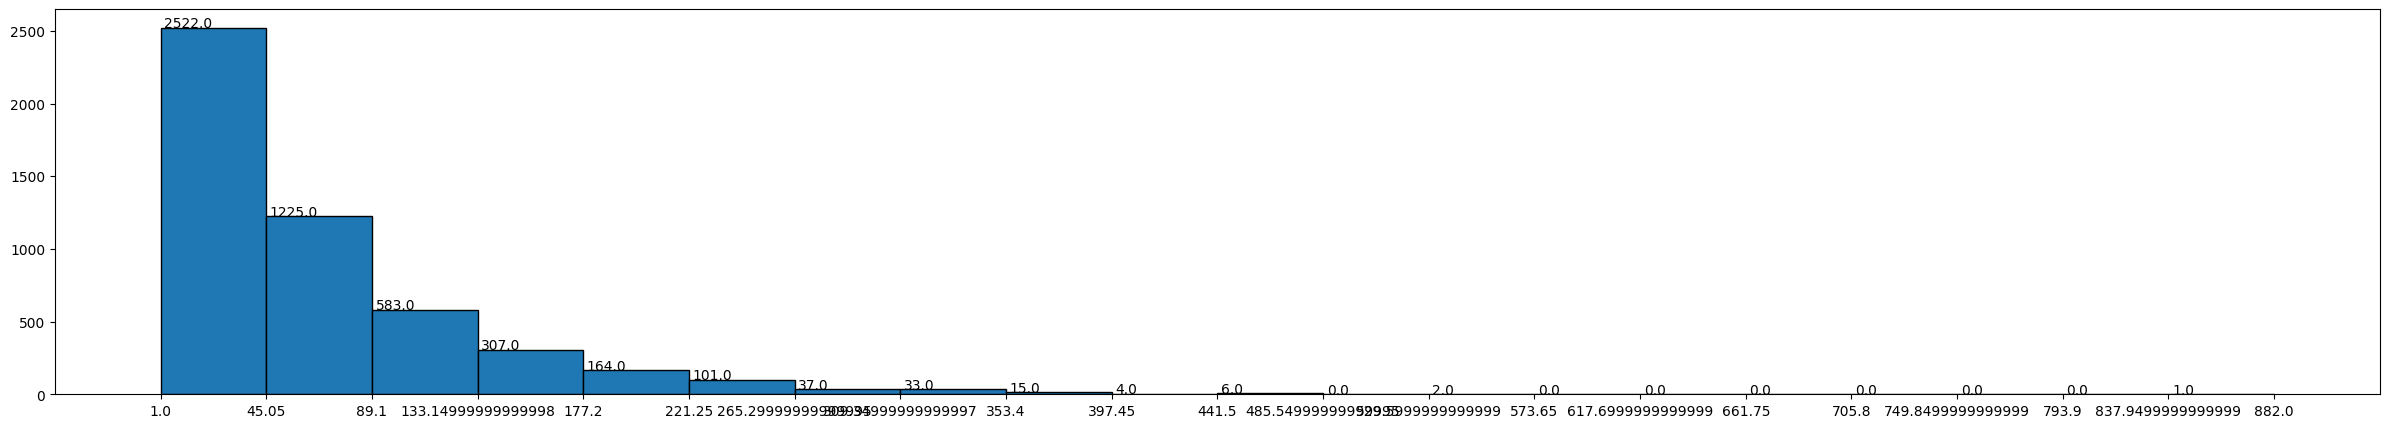

In [4]:
durations = []
for sent in data.comment.values:
    durations.append(len(sent))
plt.figure(figsize=(30, 5))
nums, bins, patches = plt.hist(durations, bins=20, edgecolor='k')
plt.xticks(bins, bins)
for num, bin in zip(nums, bins):
    plt.annotate(num, xy=(bin, num), xytext=(bin + 1.5, num + 0.5))
plt.show()

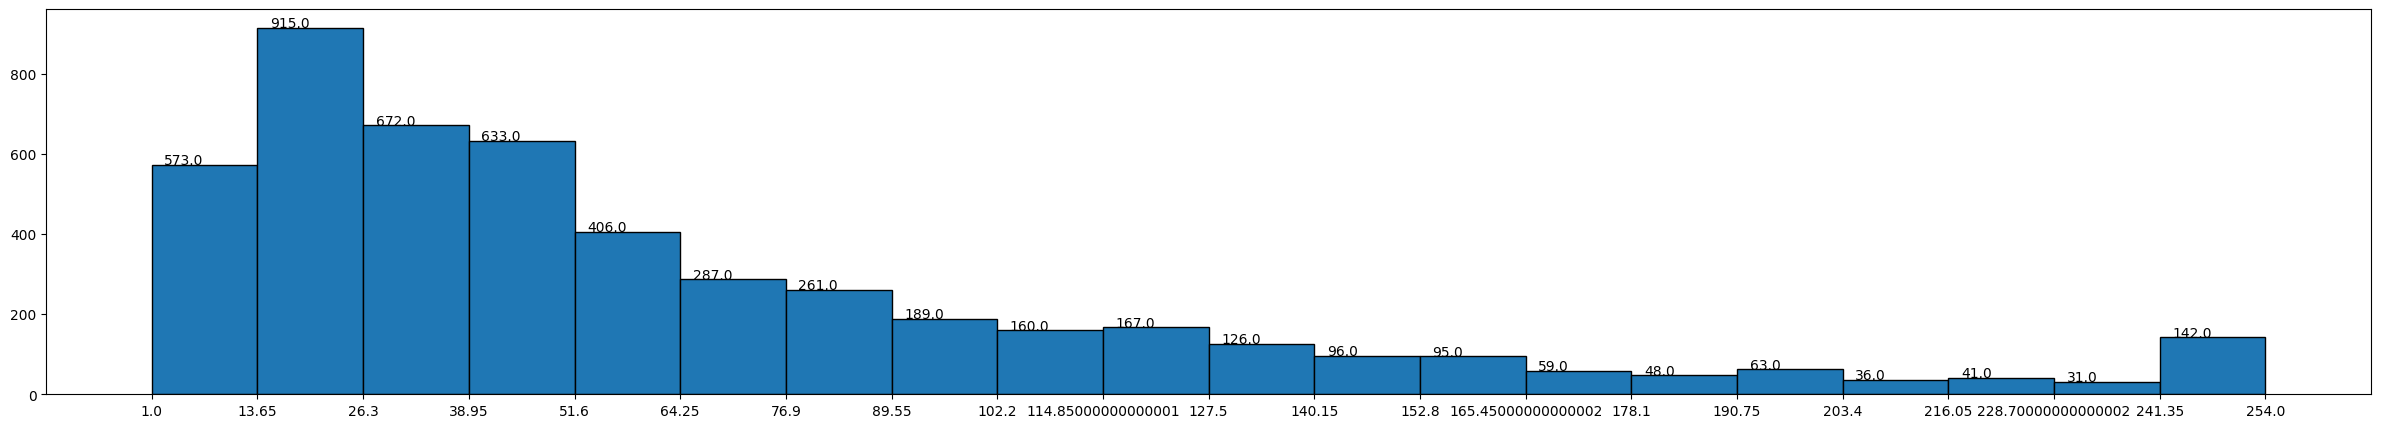

In [5]:
# keep the sentence in 512
over_id = 0
list_id = 0
list_group = []
durations = []
for sent in data.comment.values:
    if len(sent) > 254:
        over_id = list_id
        data.comment.values[over_id] = data.comment.values[over_id][0:254]
        list_group.append(over_id)
    durations.append(len(data.comment.values[list_id]))
    list_id += 1

plt.figure(figsize=(30, 5))
nums, bins, patches = plt.hist(durations, bins=20, edgecolor='k')
plt.xticks(bins, bins)
for num, bin in zip(nums, bins):
    plt.annotate(num, xy=(bin, num), xytext=(bin + 1.5, num + 0.5))
plt.show()

In [6]:
# split the data with 8:1:1
X = data.comment.values
y = data.label.values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=2022)
X_val, X_test, y_val, y_test = \
    train_test_split(X_test, y_test, test_size=0.5, random_state=2022)
# check the data
print(X_val)
print(y_val)
print(X_test)
print(y_test)

['动力是我比较吐槽的地方，也不是一无是处。主要是一二档起步，太肉，转速上去了，车速提高不明显，就是传说的不线性吧。至于长上坡？那就降档吧，速度你懂的。三档后逐渐提起速度，四档五档开起很爽。上过110码，轻松，稳定，还有上升的空间，要上到120码，应该不存在问题，由于磨合期，没敢太高。'
 '外观：外观还可以。大气上档次最满意的是这个车的外观设计，时尚大气。前脸比较像宝马。||1948884-外观'
 '座椅是仿皮的||1261261-内饰'
 '操控：我觉得很简单，看起来感觉有点笨重吧这个方向盘。但是去操作的话感觉很敏捷的刹车不重，不累。刚刚好||2481726-操控性'
 '操控：我买的自动豪华，怕那些科技联网搞不明白。现在看来还是很对的，中华V7的操作很顺畅，宝马的鸡腿档手感好，刚开始用有点不习惯，现在档位清晰换档很顺畅。V7车大，底盘高，视野也很好。方向盘很轻，高速很稳不飘，但是高速的噪音还是有点大，特别是120左右的时候。灵敏度我感觉也挺好的。刚提车一个月的时候我感觉车起步没有传说中的那种推背感，有点肉，后来跟其他车型交流慢慢适应了V7的操控现在也很完美。40迈的时候有一声咯噔，不知道哪儿的问题。'
 '1. 喜欢运动型的前排座椅带的腿托，很舒服。虽然21款不是真皮了，但是仿皮质感做的也非常到位。后排放两个腰枕，美化内饰又可满足长途乘坐舒适感。 2. 空调可以分三区单独控制，这点特别实用。3. 舒适度贡献最高的当属于已经提过的静音效果，其次就是悬挂减震。这张照片是买车那天，我和先生去吃了顿大餐庆祝，饭后海边远眺，愿一切美好从此环环相扣。由于后排主要是老人和小孩乘坐，所以什么座椅不够长且太硬角度小等，目前均没有觉得是困扰。 2. 内部静音效果超级棒： 现在最开心的事就是坐在亲爱的先生开着车的副驾驶上，关闭'
 '操控还是很灵敏的，转向也精准。这样的小车一般都比较好开。而且它的行驶品质和大众几乎是保持一致的。不太满意的就是踏板不是很线性，前半段的反馈很弱。||2965216-操控性'
 '做工材料还可以，设计老旧，导航不准，科技感不强'
 '很好，车性价比高，就是贷款买车，被4儿子强收贷款服务费，和16800装簧，完全被4S店宰的感觉！标配配置：定速巡航系统、方向盘座椅记忆功能实用。发动机启停系统鸡列，不实用！'
 '油耗：这个车油耗的话在市区跑的话相对于还是

In [7]:
# Run in GPU
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [8]:
# preprocessing the text
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Print sentence 0
print('Original: ', X[220])
print('Processed: ', text_preprocessing(X[220]))

Original:  外观是野帝的硬伤朋友叫它大北斗星，自卑感涌上心头，||1500168-外观
Processed:  外观是野帝的硬伤朋友叫它大北斗星，自卑感涌上心头，||1500168-外观


In [9]:
# load the tokenizer from bert
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=True)

In [10]:
# preprocessing function for bert
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # 预处理语句
            add_special_tokens=True,  # 加 [CLS] 和 [SEP]
            max_length=MAX_LEN,  # 截断或者填充的最大长度
            padding='max_length',  # 填充为最大长度，这里的padding在之间可以直接用pad_to_max但是版本更新之后弃用了，老版本什么都没有，可以尝试用extend方法
            return_attention_mask=True  # 返回 attention mask
        )

        # 把输出加到列表里面
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # 把list转换为tensor
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# define max len
encoded_comment = [tokenizer.encode(sent, add_special_tokens=True) for sent in data.comment.values]
max_len = max([len(sent) for sent in encoded_comment])
print('Max length: ', max_len)

MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

Max length:  256
Original:  油耗很高
Token IDs:  [101, 3779, 5450, 2523, 7770, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# convert data by preprocessing_for_bert()
print('Tokenizing data...')

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)
all_inputs, all_masks = preprocessing_for_bert(X)

# convert labels to tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)
all_labels = torch.tensor(y)

# 用于BERT微调
batch_size = 16

# creat DataLoader for train_data
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# creat DataLoader for validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# creat DataLoader for test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Tokenizing data...


In [12]:
# 自己定义的Bert分类器的类，微调Bert模型
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # 输入维度(hidden size of Bert)默认768，分类器隐藏维度，输出维度(label)
        D_in, H, D_out = 768, 64, 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-chinese')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),  # 全连接
            nn.ReLU(),  # 激活函数
            nn.Dropout(0.6),
            nn.Linear(H, D_out)  # 全连接
        )
        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # 开始搭建整个网络了
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # 为分类任务提取标记'[CLS]'的最后隐藏状态，因为要连接传到全连接层去
        last_hidden_state_cls = outputs[0][:, 0, :]
        # 全连接，计算，输出label
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [13]:
# define initialize model
def initialize_model(epochs=4):
    """
    初始化bert，优化器还有学习率，epochs就是训练次数
    """
    # 初始化Bert分类器
    bert_classifier = BertClassifier(freeze_bert=False)
    # 用GPU运算
    bert_classifier.to(device)
    # 创建优化器torch.optim.AdamW
    # optimizer = transformers.AdamW(bert_classifier.parameters(),
    optimizer = torch.optim.AdamW(bert_classifier.parameters(),
                                  lr=5e-5,  # 默认学习率
                                  eps=1e-8  # 默认精度
                                  )
    # training steps
    total_steps = len(train_dataloader) * epochs
    warm_up_ratio = 0.1
    # 学习率预热
    scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
                                                             num_warmup_steps=warm_up_ratio * total_steps,
                                                             # Default value
                                                             num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


In [14]:
# loss function
loss_fn = nn.CrossEntropyLoss()  # 交叉熵

In [15]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)


#    torch.cuda.manual_seed_all(seed_value)


# define训练模型
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    # 开始训练循环
    print("Training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # 表头
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-" * 70)

        # 测量每个epoch经过的时间
        t0_epoch, t0_batch = time.time(), time.time()

        # 在每个epoch开始时重置跟踪变量
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # 把model放到训练模式
        model.train()

        # 分batch训练
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # 把batch加载到GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # 反向传播
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 更新参数和学习率
            optimizer.step()
            scheduler.step()

            # Print每20个batch的loss和time
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # 计算40个batch的时间
                time_elapsed = time.time() - t0_batch

                # Print训练结果
                print(
                    f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # 重置batch参数
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # 计算平均loss 这个是训练集的loss
        avg_train_loss = total_loss / len(train_dataloader)

        print("-" * 70)

        # Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            # Print 整个训练集的耗时
            time_elapsed = time.time() - t0_epoch

            print(
                f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f}% | {time_elapsed:^9.2f}")
            print("-" * 70)
        print("\n")
    print("Training complete!")

In [16]:
# define evaluate function
def evaluate(model, val_dataloader):
    """
    在每个epoch后验证集上评估model性能
    """
    # model放入评估模式
    model.eval()

    # 准确率和误差
    val_accuracy = []
    val_loss = []

    # 验证集上的每个batch
    for batch in val_dataloader:
        # 放到GPU上
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            # 放到model里面去跑，返回验证集的ouput就是一行三列
            # label向量可能性，这个时候还没有归一化所以还不能说是可能性，反正归一化之后最大的就是了

        # 计算loss,已经考虑了概率偏差
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # get预测结果，这里就是求每行最大的索引，然后用flatten打平成一维
        preds = torch.argmax(logits, dim=1).flatten()  # 返回一行中最大值的序号

        # 计算准确率，这个就是俩比较，返回相同的个数, .cpu().numpy()就是把tensor从显卡上取出来然后转化为numpy类型的举证好用方法
        # 最后mean因为直接bool形了，也就是如果预测和label一样那就返回1，正好是正确的个数，求平均就是准确率了
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # 计算整体的平均正确率和loss
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [17]:
# start training model
set_seed(42)  # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)

print("Start training:\n")
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

net = BertClassifier()
print("Total number of paramerters in networks is {}  ".format(sum(x.numel() for x in net.parameters())))

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training:

Training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.619387   |     -      |     -     |   15.14  
   1    |   40    |   1.491768   |     -      |     -     |   11.91  
   1    |   60    |   1.380032   |     -      |     -     |   12.02  
   1    |   80    |   1.328908   |     -      |     -     |   12.11  
   1    |   100   |   1.242202   |     -      |     -     |   12.23  
   1    |   120   |   1.084000   |     -      |     -     |   12.30  
   1    |   140   |   1.129530   |     -      |     -     |   12.39  
   1    |   160   |   0.891767   |     -      |     -     |   12.55  
   1    |   180   |   0.909861   |     -      |     -     |   12.60  
   1    |   200   |   0.806795   |     -      |     -     |   12.66  
   1    |   220   |   0.863854   |     -      |     -     |   12.76  
   1    |   240   |   0.841334   |     -      |     -     |

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total number of paramerters in networks is 102317189  


In [18]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    preds = torch.argmax(all_logits, dim=1).cpu().numpy().flatten()
    probs = F.softmax(all_logits, dim=1).cpu().numpy().max(1)

    return preds, probs

In [19]:
# Compute predicted probabilities on the test set
predict_val, probs_val = bert_predict(bert_classifier, val_dataloader)
predict_test, probs_test = bert_predict(bert_classifier, test_dataloader)

In [20]:
def predict_sent(text):
    inputs_sent, masks_sent = preprocessing_for_bert([text])
    # Create the DataLoader for our test set
    dataset = TensorDataset(inputs_sent, masks_sent)
    sampler = SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=16)
    preds_sent, probs_sent = bert_predict(bert_classifier, dataloader)
    ps = ['投诉', '不满', '勉强', '接受，基本满足', '满意']
    ps_sent = ps[preds_sent[0]]
    return preds_sent, probs_sent, ps_sent

In [21]:
print(confusion_matrix(y_val, predict_val))
print(classification_report(y_val, predict_val))

print(confusion_matrix(y_test, predict_test))
print(classification_report(y_test, predict_test))

[[101   1   1   1   0]
 [  1 101   4   0   0]
 [  4   4  97  13   0]
 [  0   1  11  79   0]
 [  3   4   0   1  73]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       104
           1       0.91      0.95      0.93       106
           2       0.86      0.82      0.84       118
           3       0.84      0.87      0.85        91
           4       1.00      0.90      0.95        81

    accuracy                           0.90       500
   macro avg       0.91      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500

[[ 87   2   4   0   0]
 [  2  86   7   0   0]
 [  3   6  70  11   1]
 [  0   1  22  85   1]
 [  2   0   0   5 105]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        93
           1       0.91      0.91      0.91        95
           2       0.68      0.77      0.72        91
           3       0.84      0.78      0.81       109
        

In [22]:
data_contrast = pd.DataFrame({'comment': X_val, 'label': y_val, 'predict': predict_val, 'probability': probs_val})
data_contrast.to_csv('/content/data-contrast-val.csv',encoding='UTF-8')

data_contrast = pd.DataFrame({'comment': X_test, 'label': y_test, 'predict': predict_test, 'probability': probs_test})
data_contrast.to_csv('/content/data-contrast-test.csv',encoding='UTF-8')

In [23]:
#%%
print(predict_sent('油耗低'))
print(predict_sent('油耗很低'))
print(predict_sent('油耗不低'))
print(predict_sent('油耗高'))
print(predict_sent('油耗很高'))
print(predict_sent('油耗不高'))
print(predict_sent('不明觉厉'))

(array([3]), array([0.8692232], dtype=float32), '接受，基本满足')
(array([4]), array([0.9104346], dtype=float32), '满意')
(array([2]), array([0.47653243], dtype=float32), '勉强')
(array([1]), array([0.9804034], dtype=float32), '不满')
(array([0]), array([0.99214387], dtype=float32), '投诉')
(array([3]), array([0.75981206], dtype=float32), '接受，基本满足')
(array([1]), array([0.9735643], dtype=float32), '不满')


In [24]:
autohome_data = pd.read_csv(
    r'/content/dsc_up_origins3.csv')

data_apperance = autohome_data.apperance.values
data_comfortableness = autohome_data.comfortableness.values
data_consumption = autohome_data.consumption.values
data_costefficient = autohome_data.costefficient.values
data_internal = autohome_data.internal.values
data_maneuverability = autohome_data.maneuverability.values
data_power = autohome_data.power.values
data_space = autohome_data.space.values

In [25]:
def predict_newdata(data):
    list_id = 0
    list_group = []
    durations = []
    for sent in data:
        if pd.isnull(sent) or type(sent) == int:
            data[list_id] = ''

        elif len(sent) > 254:
            #over_id = list_id
            data[list_id] = data[list_id][0:254]
            list_group.append(list_id)
        durations.append(len(data[list_id]))
        list_id += 1

    plt.figure(figsize=(30, 5))
    nums, bins, patches = plt.hist(durations, bins=20, edgecolor='k')
    plt.xticks(bins, bins)
    for num, bin in zip(nums, bins):
        plt.annotate(num, xy=(bin, num), xytext=(bin + 1.5, num + 0.5))
    plt.show()

    inputs, masks = preprocessing_for_bert(data)
    dataset = TensorDataset(inputs, masks)
    sampler = SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=16)
    predict, probas = bert_predict(bert_classifier, dataloader)

    return predict, probas

apperance is processing


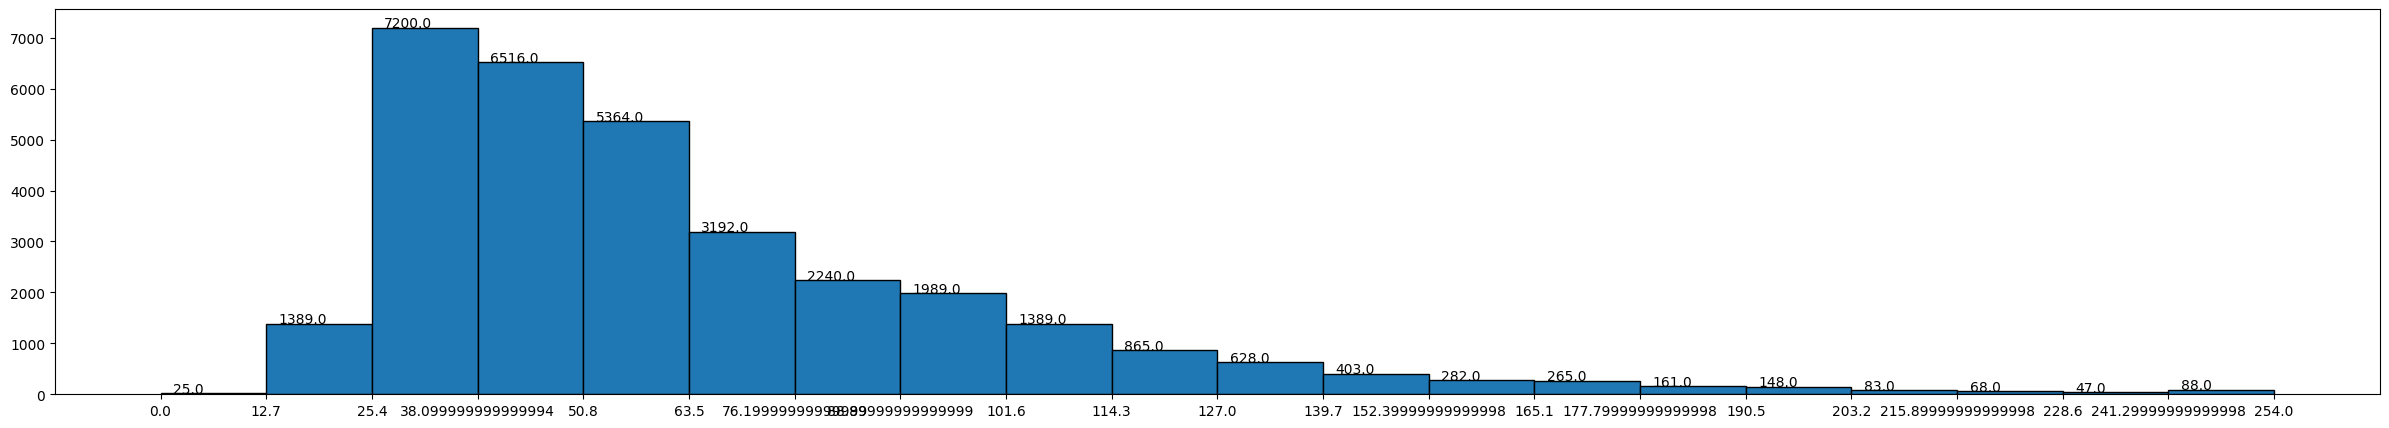

comfortableness is processing


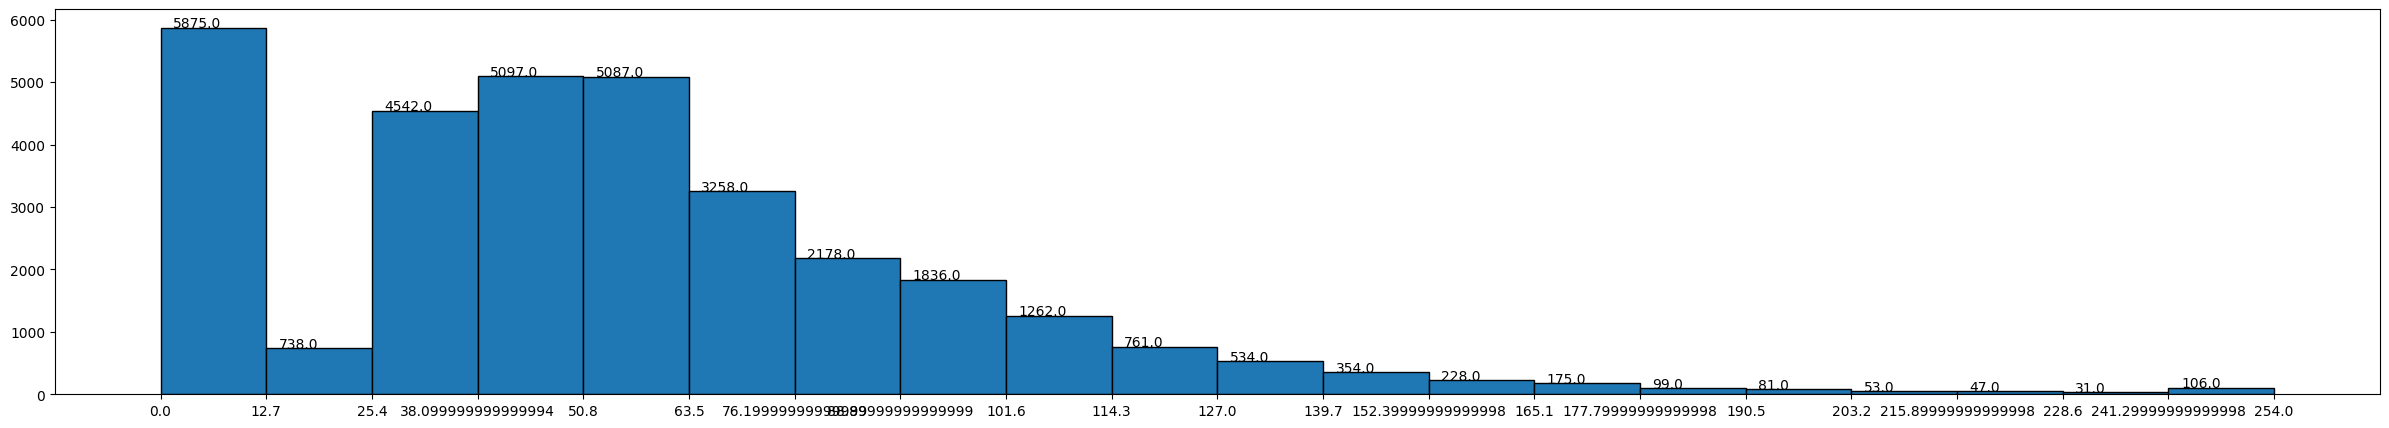

consumption is processing


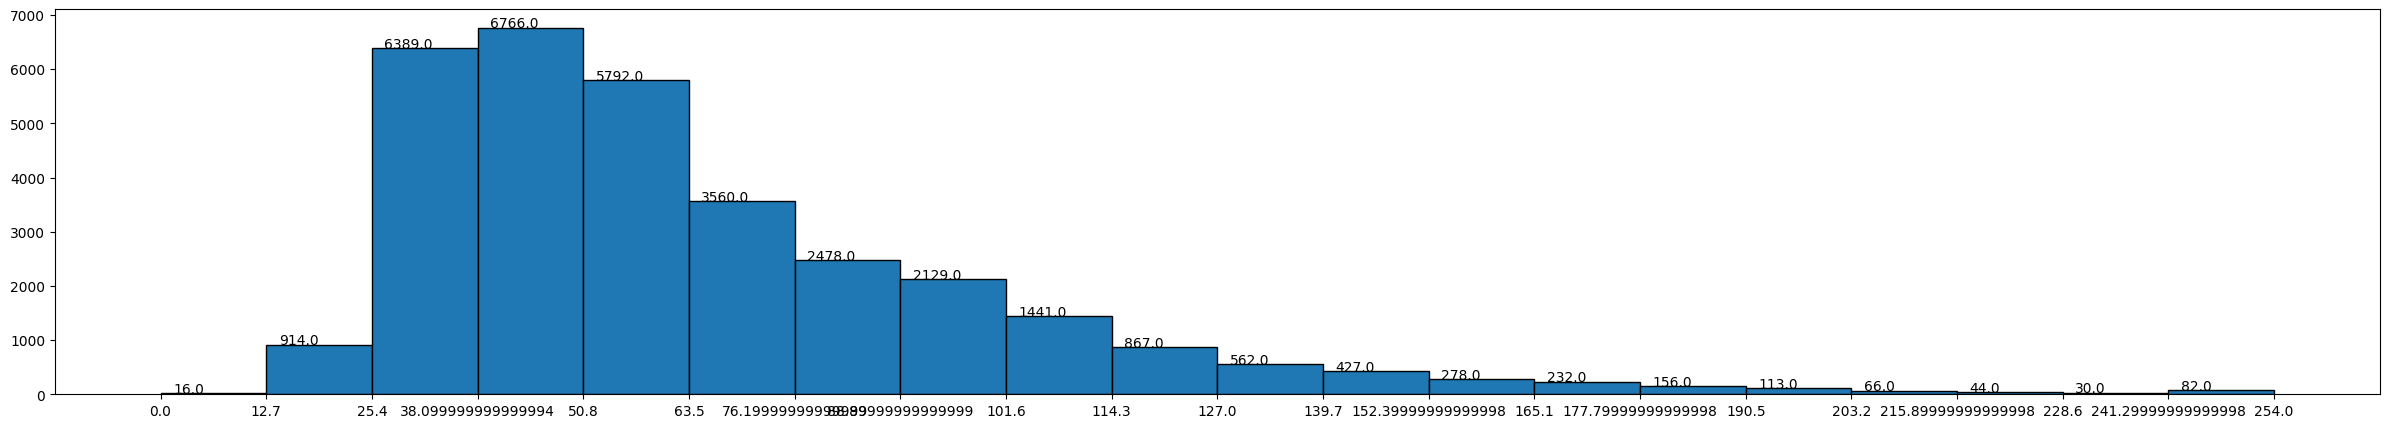

costefficient is processing


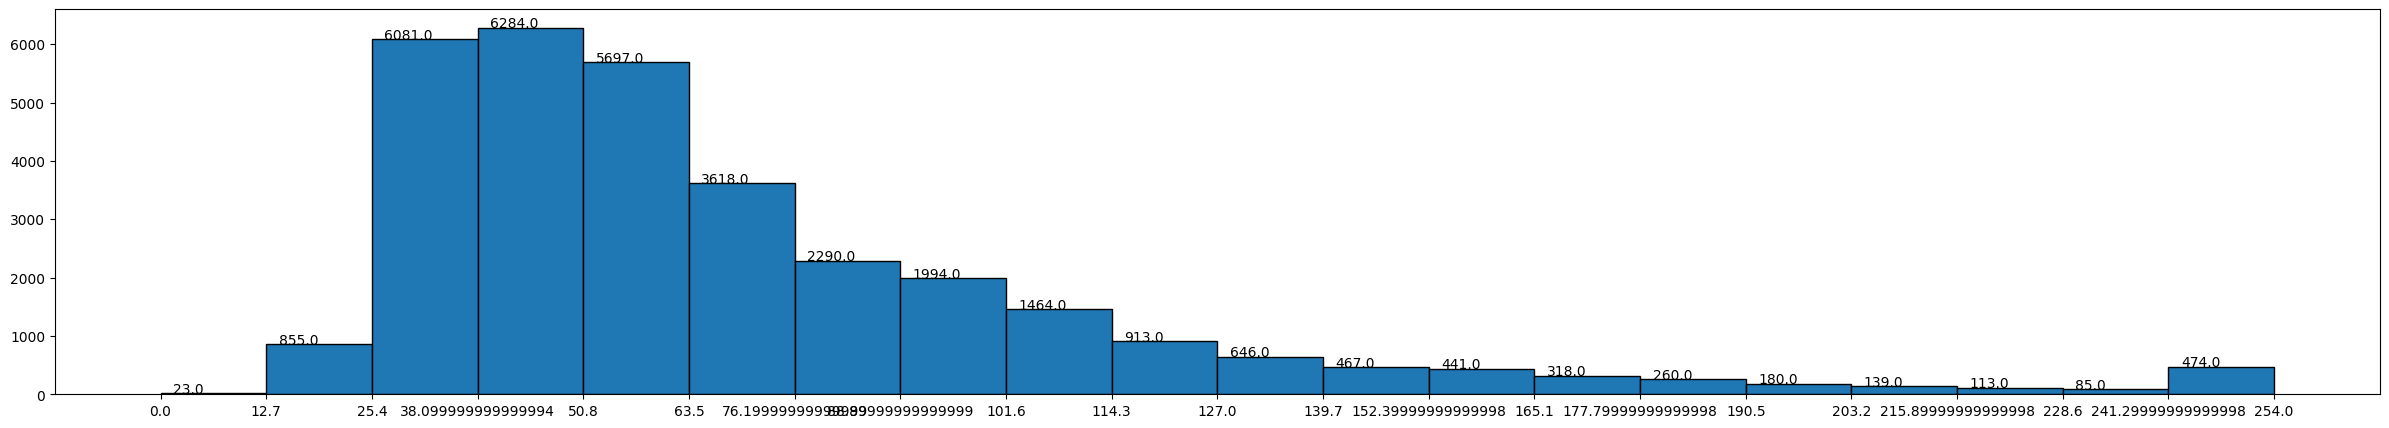

internal is processing


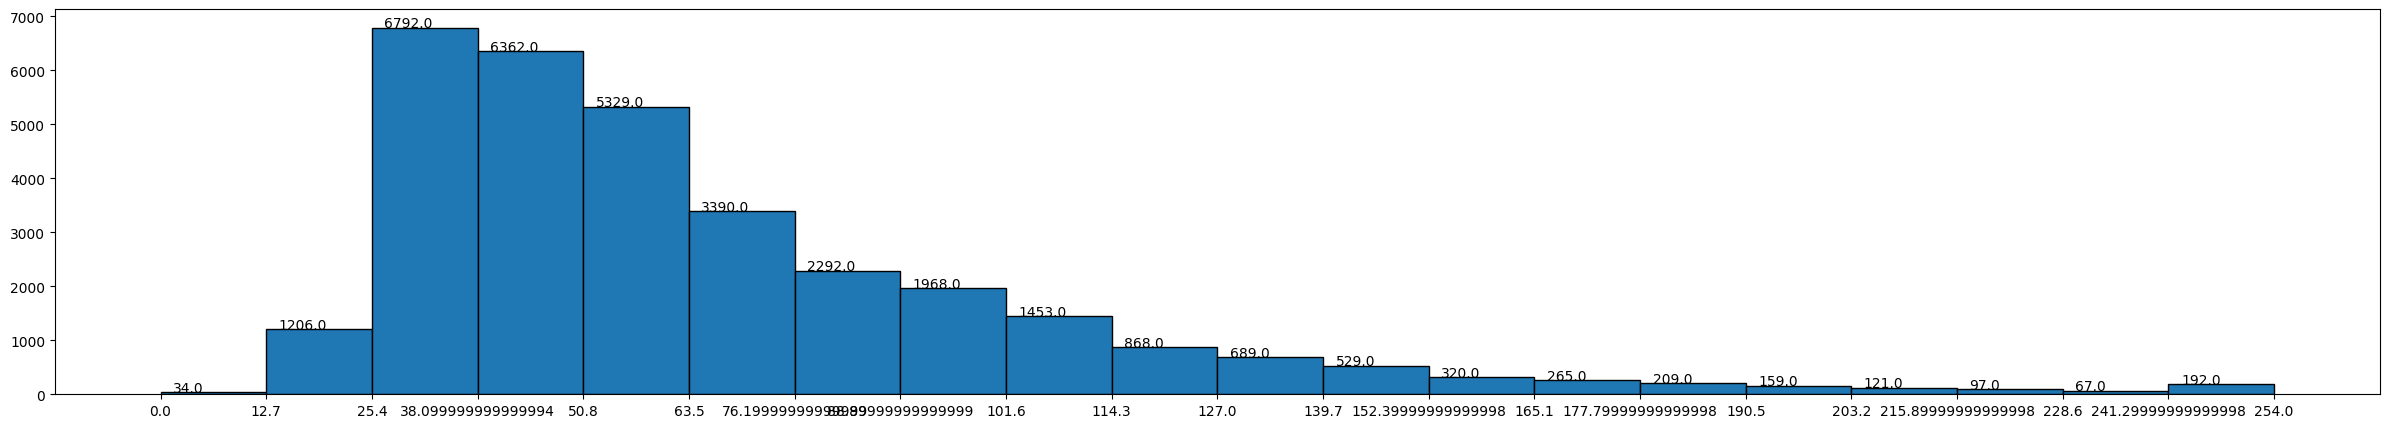

maneuverability is processing


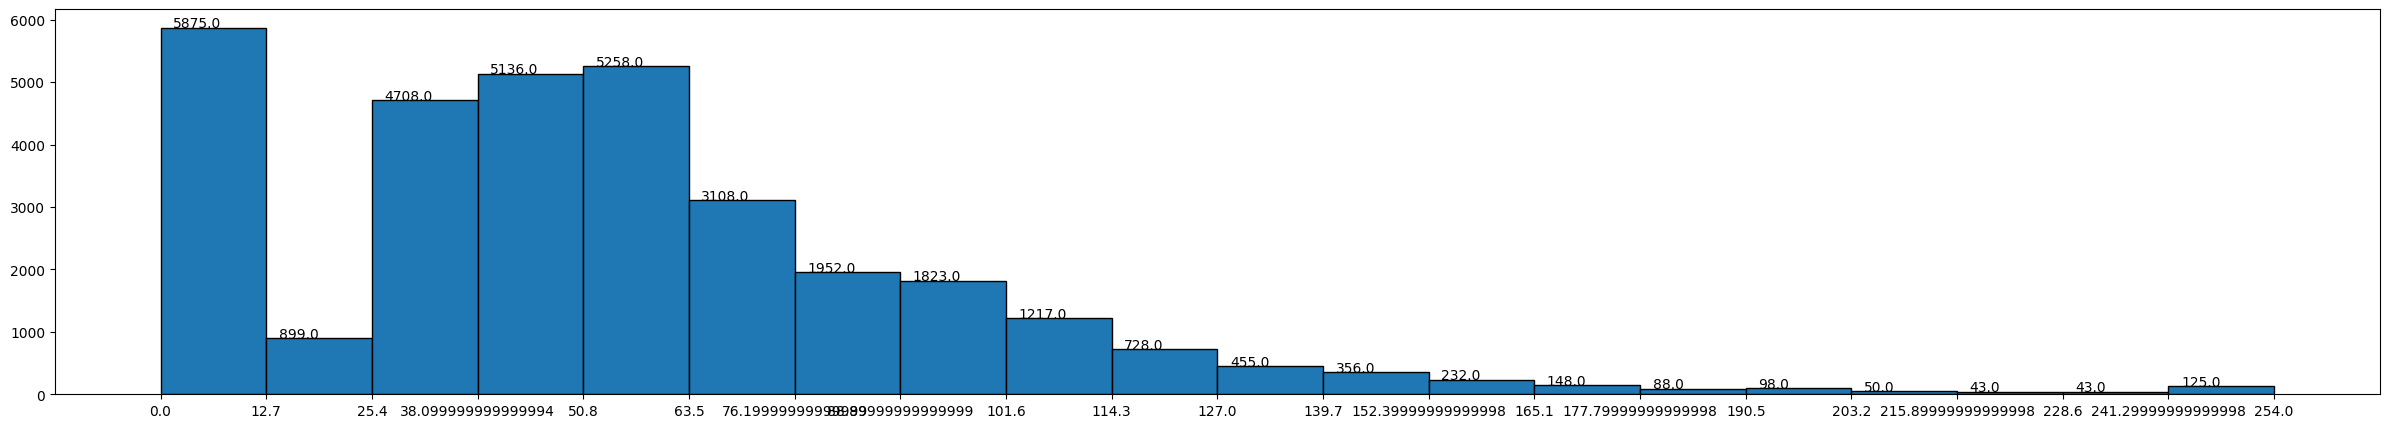

power is processing


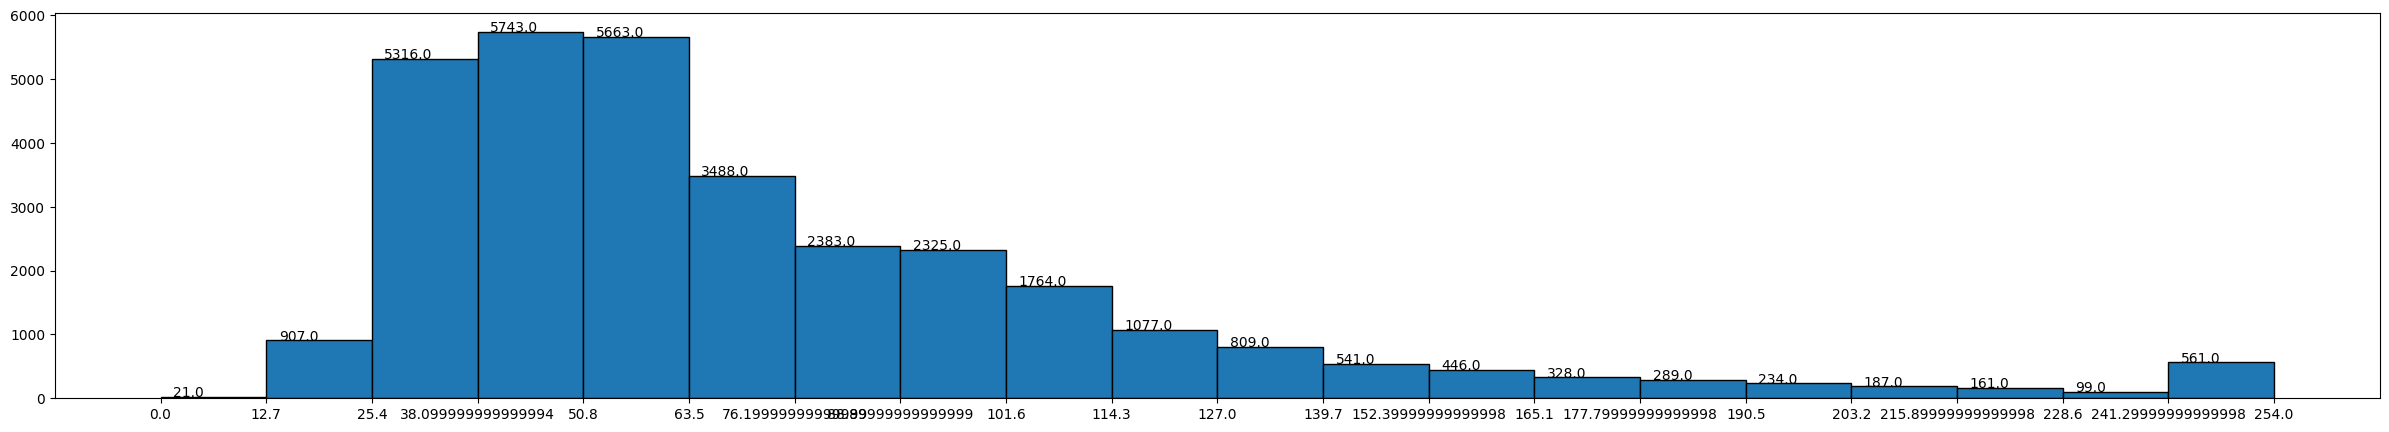

space is processing


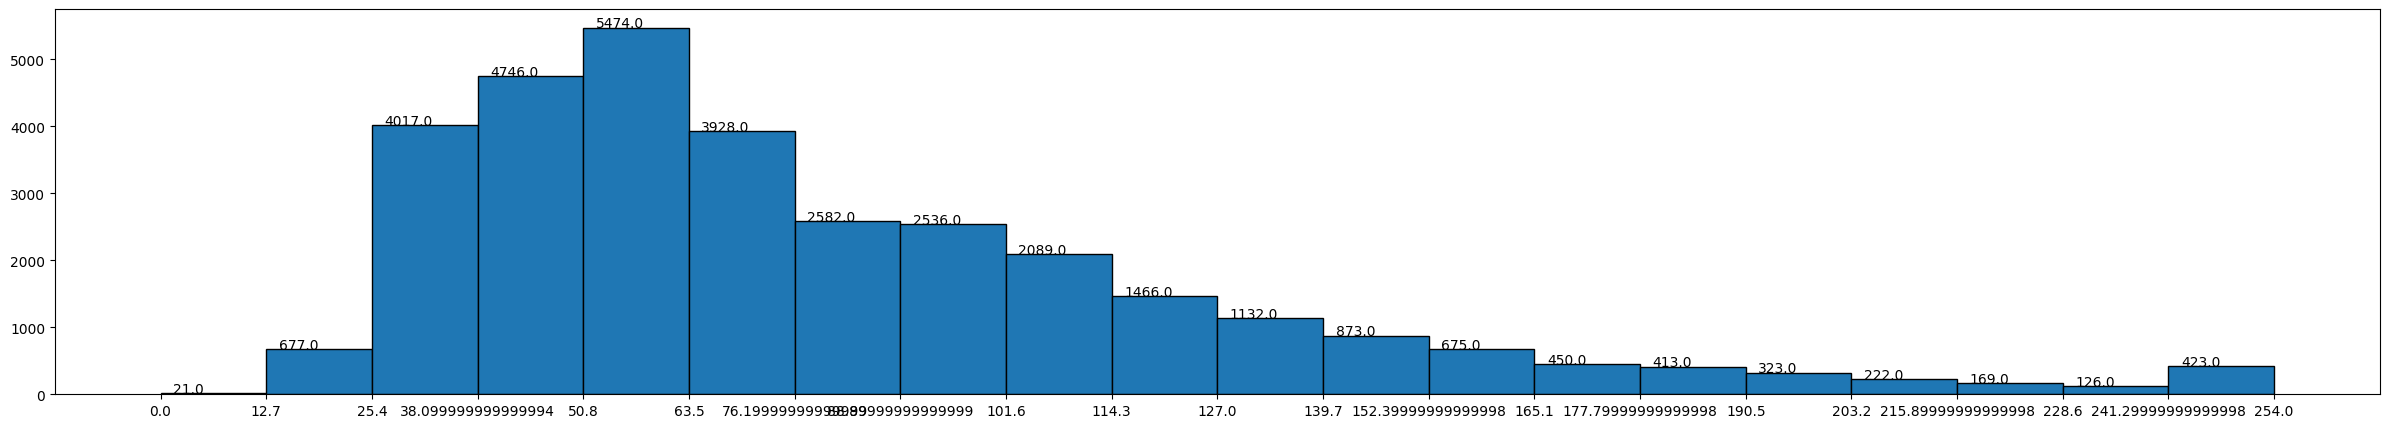

In [27]:
count = 0
list = ['apperance', 'comfortableness', 'consumption', 'costefficient', 'internal', 'maneuverability', 'power',
        'space']
for data in [data_apperance, data_comfortableness, data_consumption, data_costefficient, data_internal,
             data_maneuverability, data_power, data_space]:
    print(f'{list[count]} is processing')
    predict, probas = predict_newdata(data)
    data_pd = pd.DataFrame({'comment': data, 'predict': predict, 'probability': probas})
    data_pd.to_csv(
        f'/content/predict_{list[count]}.csv',encoding='UTF-8')
    count += 1